# Instructions

1. This exam is worth 20% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. It is a take-home EXAMINATION to assess your understanding of the material, and extend the ideas by learning on your own. 
2. You are required to work on it individually. Any form of plagiarism will result in 0.
2. Good, efficient Python code will get more marks than code that is not neat, difficult to understand and least importantly, slow.
3. Please submit your notebook file (name it `IND5003_THE_<Your_Name>.ipynb`) through Canvas before **15th Oct 2023 23:59hrs**.

# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from numpy.random import default_rng

from myscripts import clust
%matplotlib inline

After importing the necessary libraries, we define the functions that would be used in the program. 

First, we define the scaling function. The function takes the input data using the StandardScaler class from scikit-learn and ensures that all features have a similar scale, which can improve the performance of clustering algorithms.

In [19]:
#Funtion to scale the data to have similar scale for effective clustering
def scale_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

The next function "calculate_clustering_metrics" calculates the cophenetic correlation coefficient and silhouette scores for each combination of method and metric. 

Cophenetic correlation is a measure of how well a hierarchical clustering dendrogram reflects the actual pairwise distances between data points.
Silhouette score is a measure of how well each data point is assigned to its cluster.

This study looks at 4 methods ('single', 'complete', 'average','ward') and 2 metrics (Euclidean and Manhatten). As the linkage() function in the scipy.cluster.hierarchy recognises the 'cityblock' metric instead of the 'Manhatten' metric  although they are the same thing. The code has to be modified slightly to reflect the 'manhatten' naming after the calculations are done. 

The ward method is not applicable for the 'cityblock' metric, thus the code will disregard the need for calculation if the method is 'ward' and metric is 'cityblock'. 

In [20]:
def calculate_clustering_metrics(data, methods, metrics):
    coph_results = {}
    silhouette_results = {}
    for metric in metrics:
        distance_matrix = pdist(data, metric=metric)
        for method in methods:
            if method == 'ward' and metric != 'euclidean':
                continue
            hierarchy = linkage(distance_matrix, method=method)
            coph_corr, _ = cophenet(hierarchy, distance_matrix)
            coph_results[(method, metric)] = coph_corr

            silhouette_scores = []
            for n_clusters in range(2, 11):
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
                labels = model.fit_predict(data)
                silhouette_scores.append(silhouette_score(data, labels))
            silhouette_results[(method, metric)] = (silhouette_scores, np.argmax(silhouette_scores) + 2)
    return coph_results, silhouette_results



After the computations are done, the following two functions displays the results in table and bar chart format. 

This function "display_and_visualize_cophenetic_metrics" displays and visualizes the cophenetic correlation results.

In [21]:
def display_and_visualize_cophenetic_metrics(coph_results, methods, metrics):
    table_data = {method: [coph_results.get((method, metric), '-') for metric in metrics] for method in methods}
    df_coph_transformed = pd.DataFrame(table_data, index=metrics)
    df_coph_transformed.index = df_coph_transformed.index.map(lambda x: 'Manhattan' if x == 'cityblock' else x.capitalize())
    print("Cophenetic Correlation Table:")
    print(tabulate(df_coph_transformed, headers='keys', tablefmt='grid'))
    print("\n\n")
    
    bar_width = 0.25
    index = np.arange(len(methods))
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(metrics):
        values = [coph_results.get((method, metric), 0) for method in methods]
        label = 'Manhattan' if metric == 'cityblock' else metric.capitalize()
        plt.bar(index + bar_width * i, values, bar_width, label=label)

    plt.title("Cophenetic Correlation Coefficients by Distance")
    plt.ylabel('Cophenetic Correlation')
    plt.xticks(index + bar_width, methods)
    plt.legend()
    plt.tight_layout()
    plt.show()

This function "display_and_visualize_silhouette_metrics" displays and visualizes the silhouette score results in a table and a bar chart.

In [22]:
def display_and_visualize_silhouette_metrics(silhouette_results, methods, metrics):
    optimal_clusters = {}
    
    # Bar graph display
    table_silhouette_data = {method: [max(silhouette_results.get((method, metric), ([0], 0))[0]) if silhouette_results.get((method, metric)) else '-' for metric in metrics] for method in methods}
    df_silhouette_transformed = pd.DataFrame(table_silhouette_data, index=metrics)
    df_silhouette_transformed.index = df_silhouette_transformed.index.map(lambda x: 'Manhattan' if x == 'cityblock' else x.capitalize())
    print("\nMaximum Silhouette Scores Table:")
    print(tabulate(df_silhouette_transformed, headers='keys', tablefmt='grid'))
    print("\n\n")
    
    bar_width = 0.25
    index = np.arange(len(methods))
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(metrics):
        values = [max(silhouette_results.get((method, metric), ([0], 0))[0]) if silhouette_results.get((method, metric)) else 0 for method in methods]
        label = 'Manhattan' if metric == 'cityblock' else metric.capitalize()
        plt.bar(index + bar_width * i, values, bar_width, label=label)
    plt.title("Maximum Silhouette Scores by Distance")
    plt.ylabel('Silhouette Score')
    plt.xticks(index + bar_width, methods)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Line graph display
    for metric in metrics:
        plt.figure(figsize=(12, 5))
        for method in methods:
            if (method, metric) not in silhouette_results:
                metric = 'Manhattan' if metric == 'cityblock' else metric.capitalize()
                print(f"Warning: Silhouette results for method {method}, metric {metric} not available.")
                continue
            
            scores, best_n_cluster = silhouette_results.get((method, metric), ([0], 0))
            optimal_clusters[(method, metric)] = best_n_cluster
            
            if len(scores) == 9:
                plt.plot(range(2, 11), scores, '-o', label=f"{method} linkage")
                plt.scatter(best_n_cluster, max(scores), s=200, c='r', marker='X')
            else:
                print(f"Warning: Unexpected number of silhouette scores for method {method}, metric {metric}: {scores}")
        
        metric = 'Manhattan' if metric == 'cityblock' else metric.capitalize()
        plt.title(f"Silhouette Scores by Number of Clusters using {metric} distance")
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    # Printing optimal clusters table
    print("\nOptimal Cluster Numbers:")
    table_data = {method: [optimal_clusters.get((method, metric), '-') for metric in metrics] for method in methods}
    df_clusters = pd.DataFrame(table_data, index=metrics)
    df_clusters.index = df_clusters.index.map(lambda x: 'Manhattan' if x == 'cityblock' else x.capitalize())
    print(tabulate(df_clusters, headers='keys', tablefmt='grid'))



This function "plot_dendrogram" plots a dendrogram for the given method, metric, and data. A dendrogram is a tree-like diagram that shows the hierarchical relationships between clusters.

In [23]:
def plot_dendrogram(data, method, metric, max_d=200):
    linked = linkage(data, method=method, metric=metric)
    plt.figure(figsize=(10, 5))
    plt.title(f'Dendrogram using {method} linkage and {metric} metric')
    dendrogram(linked, p=20, truncate_mode='level')
    plt.axhline(y=max_d, c='k')
    plt.show()



This function "analyze_clusters" calculates and displayes the aggregate analysis and cluster value counts for the given method, metric, and data. The other function "silhouette_optimal_cluster_number" compute silhouette scores for a range of cluster numbers and return the number of clusters with the highest silhouette score.

In [24]:
def analyze_clusters(data, original_data, method='average', metric='euclidean', max_clusters=6, variables=None):
    
    # Clustering
    hierarchy = linkage(data, method=method, metric=metric)
    n_clusters = silhouette_optimal_cluster_number(data, hierarchy, max_clusters)
    
    # Assigning clusters
    cluster_labels = AgglomerativeClustering(n_clusters=n_clusters, linkage=method).fit_predict(data)
    df_analysis = pd.DataFrame(data, columns=original_data.columns)  # Fixed line
    df_analysis['groups'] = cluster_labels
    
    # Analysis
    agg_analysis = df_analysis.groupby('groups').agg([np.median, lambda x: np.quantile(x, .75) - np.quantile(x, .25)])
    print("Aggregate Analysis:")
    print(agg_analysis)
    
    # Value Counts
    print("\nCluster Value Counts:")
    print(tabulate(pd.DataFrame(df_analysis['groups'].value_counts().reset_index()), headers=['Cluster', 'Count'], tablefmt='grid'))
      
    return df_analysis

def silhouette_optimal_cluster_number(data, hierarchy, max_clusters):
 
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        cluster_labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(data)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
    
      
    return np.argmax(silhouette_scores) + 2 


This part onwards is where the main script starts. We first read the data into a datafile 'df' from where we would start the processing. We would then study the first 5 lines of the data to understand its headers and also its shape.

In [33]:
# Main script begins here 
# Load data
df = pd.read_csv('../data/MRCI_clus_2310.csv')

# Study data set for heading and shape
df.head(n=5)


,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
0,0.7160,954.0,0.2807,0.5940,18.0
1,0.8854,1266.0,0.6245,0.6210,19.0
2,0.7367,1300.0,0.6072,0.4047,19.0
3,0.9799,955.0,0.2843,0.6495,13.0
4,0.7890,1244.0,0.7223,0.5615,19.0


In [34]:
df.shape

(856, 5)

The data has 856 rows with 5 columns (ADM_RATE, SAT_AVG, C150_4, UGDS_WOMEN and STUFACR). This means there are 4285 data points to compute.

We would now scale the data, define the methods and metrics used and start the calculations.

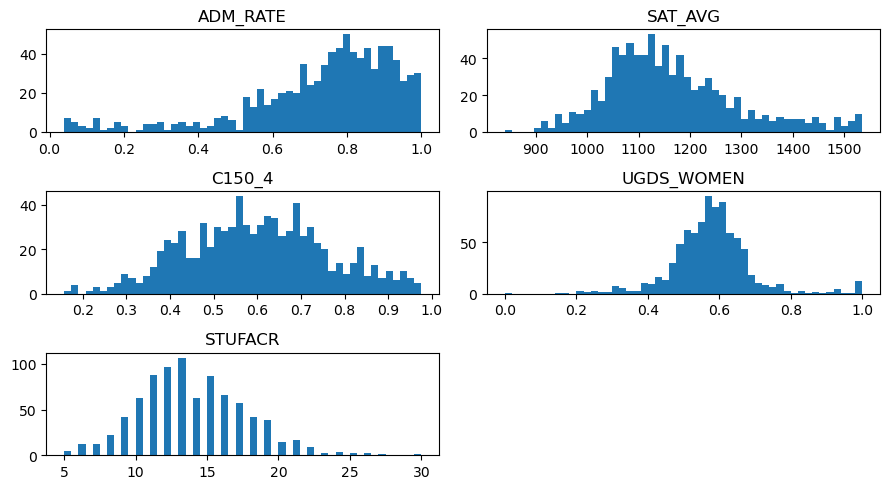

In [14]:
df[['ADM_RATE', 'SAT_AVG', 'C150_4', 'UGDS_WOMEN','STUFACR']].hist(figsize=(9,5), grid=False, bins=50);
plt.tight_layout()

Looking at the histograms of the 5 variables to be studied, it can be seen that the variable are largely normal distrubuted while ADM_RATE is left skewed. 

In [15]:
scaled_data = scale_data(df)

methods = ['single', 'complete', 'average','ward']
metrics = ['euclidean', 'cityblock']

coph_results, silhouette_results = calculate_clustering_metrics(scaled_data, methods, metrics)

We would display the calculated Cophenetic Correlation data in a table and bar chart for visual purpose.  

Cophenetic Correlation Table:
+-----------+----------+------------+-----------+--------------------+
|           |   single |   complete |   average | ward               |
+===========+==========+============+===========+====================+
| Euclidean | 0.581313 |   0.538023 |  0.766597 | 0.5723214644160851 |
+-----------+----------+------------+-----------+--------------------+
| Manhattan | 0.562279 |   0.640836 |  0.709182 | -                  |
+-----------+----------+------------+-----------+--------------------+





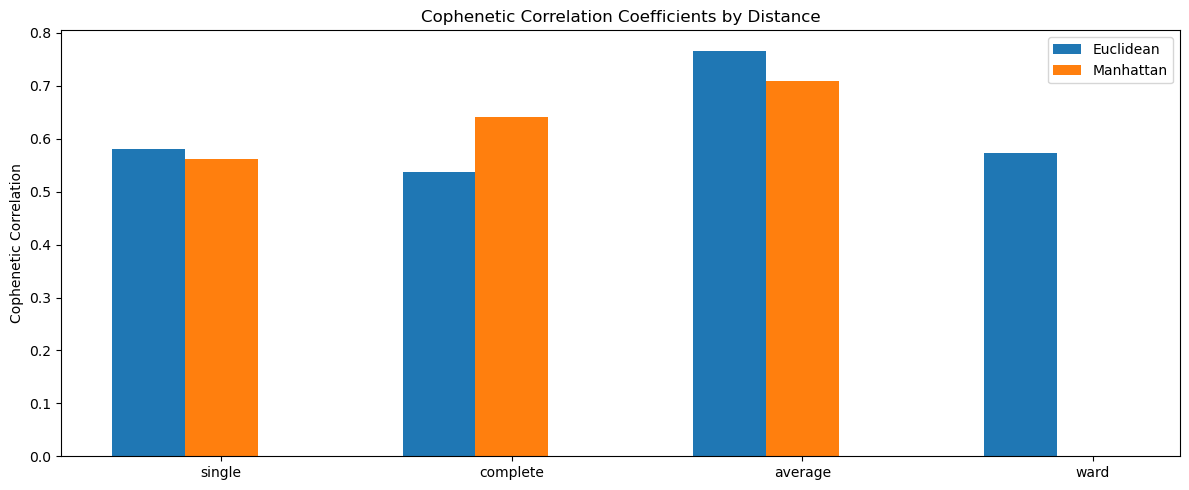

In [16]:
display_and_visualize_cophenetic_metrics(coph_results, methods, metrics)


A good cophenetic coefficient is one that is close to 1.0. A cophenetic coefficient of 1.0 indicates that a dendrogram, when charted, will  perfectly reflects the actual pairwise distances between data points. In practice, it is unrealistic to expect a cophenetic coefficient of 1.0, but a cophenetic coefficient of 0.7 or higher is generally considered to be good.

The factors that can affect the cophenetic coefficient are (1) the clustering algorithm / method used, (2) the distance metric used and (3) the quality of the data. For this study, we are comparing the Euclidean and Manhattan methods and their respective use of the single, complete, average and ward distance metrics. 

From the given data, it is clear that the average linkage metric provides the highest cophenetic scoring among all 4 options for both Euclidean and Manhattan methods with scores of 0.767 and 0.709 respectively. If based on only this manner of comparision, we can conclude that using the Average Metric for Euclidean Method is the most effective. 

We would now look at the Silhouette scores to confirm if the above conclusion is valid.


Maximum Silhouette Scores Table:
+-----------+----------+------------+-----------+---------------------+
|           |   single |   complete |   average | ward                |
+===========+==========+============+===========+=====================+
| Euclidean | 0.362268 |   0.197351 |  0.479419 | 0.38297539650136647 |
+-----------+----------+------------+-----------+---------------------+
| Manhattan | 0.362268 |   0.197351 |  0.479419 | -                   |
+-----------+----------+------------+-----------+---------------------+





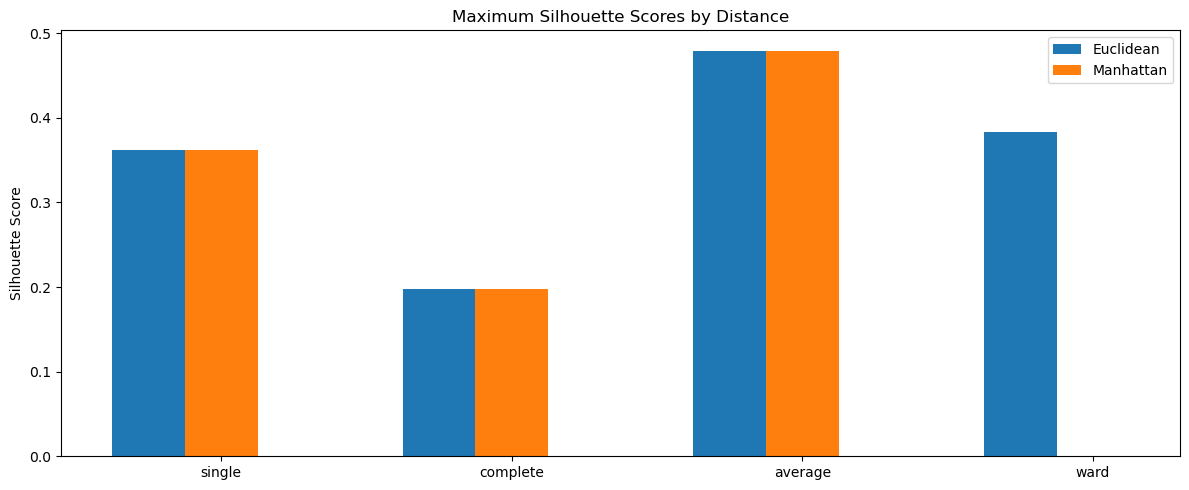

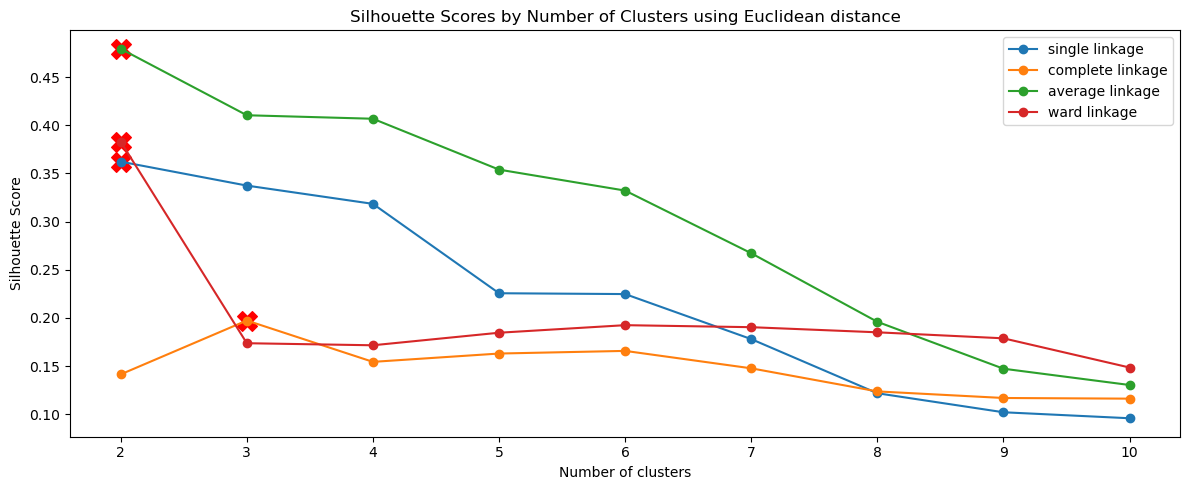

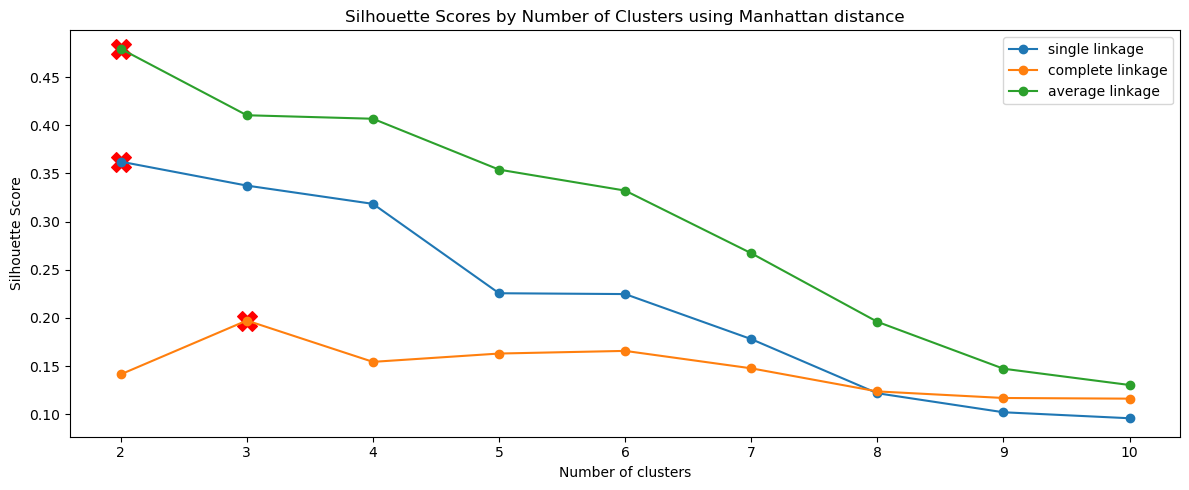


Optimal Cluster Numbers:
+-----------+----------+------------+-----------+--------+
|           |   single |   complete |   average | ward   |
+===========+==========+============+===========+========+
| Euclidean |        2 |          3 |         2 | 2      |
+-----------+----------+------------+-----------+--------+
| Manhattan |        2 |          3 |         2 | -      |
+-----------+----------+------------+-----------+--------+


In [17]:
display_and_visualize_silhouette_metrics(silhouette_results, methods, metrics)

A good silhouette score is one that is close to 1.0. A silhouette score of 1.0 indicates that each data point is perfectly assigned to its cluster. In practice, it is unrealistic to expect a silhouette score of 1.0, but a silhouette score of 0.5 or higher is generally considered to be good. The factors that can affect the silhouette scores are the same as those that affect the cophenetic correlation coefficient. 

From the table and bar charts shown, the average linkage metric scores the highest again for Euclidean and Manhattan methods with same score of 0.479. While this is lower that the 0.5 score target, it is higher than the other scores of 0.38 and lower. 

As for the optimum clustering, the line graphs shows the optimal clustering for the average linkage metric is 2 clusters which is on par with the single and ward metrics.  

We can conclude that the Euclidean method with average linkage metric is the most effective way to cluster the data. We would use dendrograms to confirm the findings.

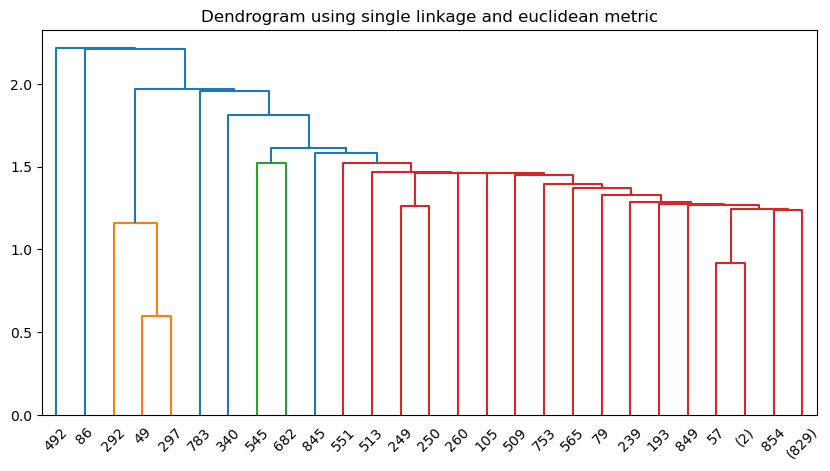

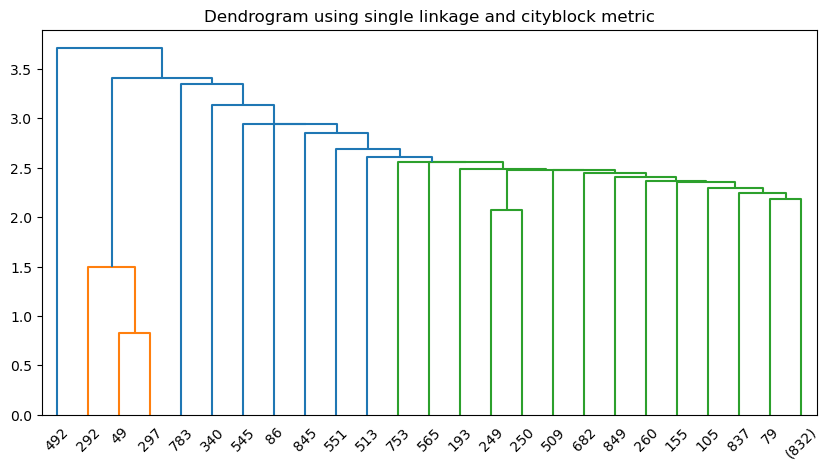

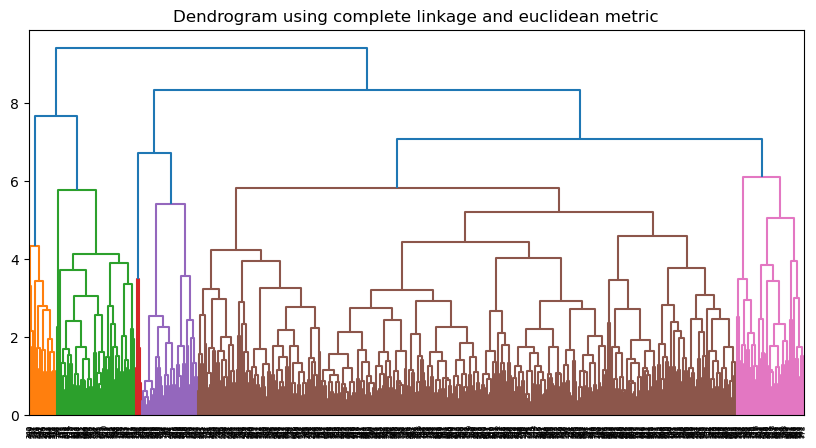

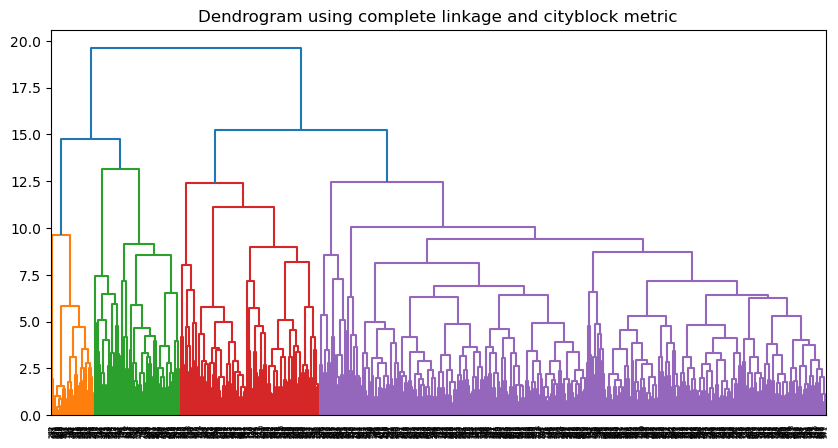

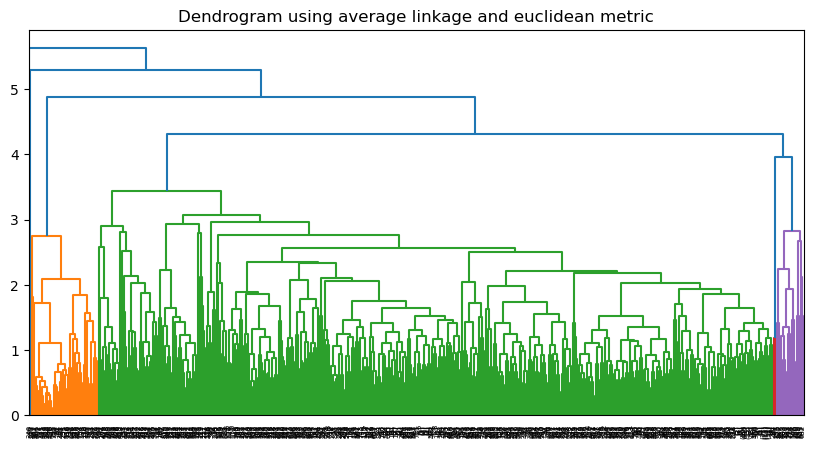

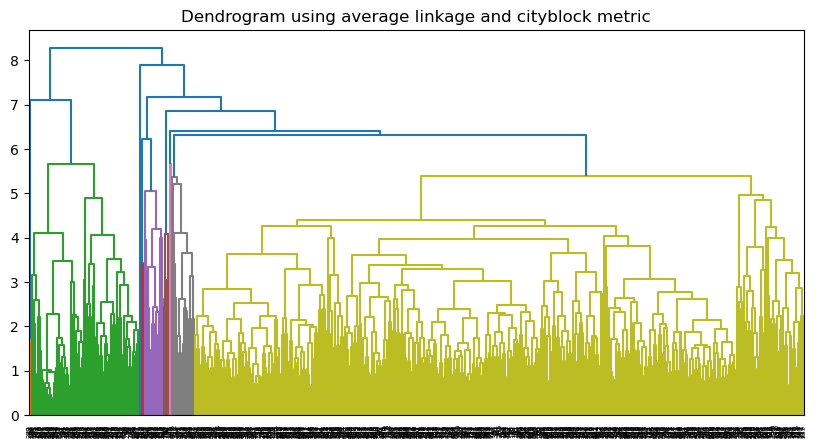

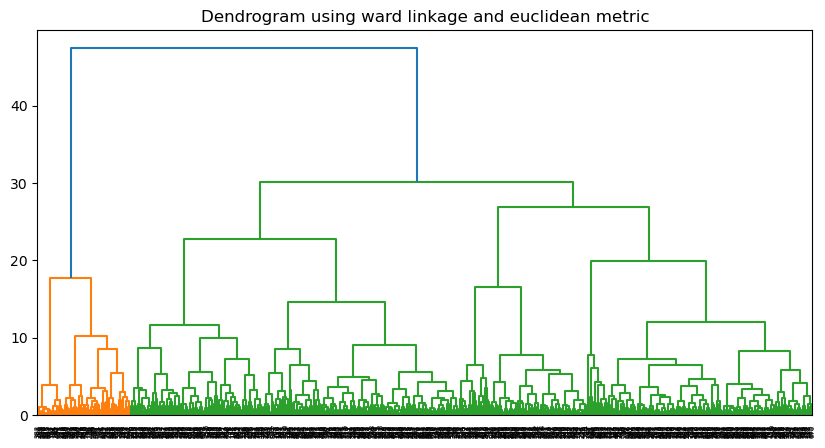

In [12]:
for method in methods:
    for metric in metrics:
        if method == 'ward' and metric != 'euclidean':
            continue  # Skip non-Euclidean metric for 'ward' method
        plot_dendrogram(scaled_data, method, metric)

The dendrograms for the average linkage metric shows that the branching starts at the lower levels as compare to the other dendrograms and have clear differentiations in clusterings. Between the average average linkage metrics, there are Euclidean method is able to effectively combine the clusters into one main branch vs the spread for the Manhatten method is diverese. 

As such, we can conclude that the Euclidean method with average linkage metric is the most effective way to cluster the data.

In [13]:
variables_to_plot = ["ADM_RATE", "SAT_AVG", "C150_4", "UGDS_WOMEN", "STUFACR"]
analyzed_data = analyze_clusters(scaled_data, df, variables=variables_to_plot)

Aggregate Analysis:
        ADM_RATE              SAT_AVG               C150_4             \
          median <lambda_0>    median <lambda_0>    median <lambda_0>   
groups                                                                  
0       0.221891   1.159776 -0.191147   1.223331 -0.009203   1.393318   
1       0.743395   0.000000  0.387297   0.000000  1.148303   0.000000   

       UGDS_WOMEN              STUFACR             
           median <lambda_0>    median <lambda_0>  
groups                                             
0        0.006969   0.998979 -0.203263   1.338406  
1       -5.004871   0.000000 -0.738625   0.000000  

Cluster Value Counts:
+----+-----------+---------+
|    |   Cluster |   Count |
+====+===========+=========+
|  0 |         0 |     855 |
+----+-----------+---------+
|  1 |         1 |       1 |
+----+-----------+---------+


From the Cluster Value Count table, it is interesting that all except one node is inside one cluster. This could mean that (1) the clustering method is ineffective, (2) errors in the dataset or (3) one major outlier in the dataset.In this case, both the the Cophentic Correlation and Silhouette scores validated the use of the Euclidean Method with Average Metric. Thus the clustering method is suitable for you. If there was errors in the dataset, then there would be more cases of inconsistencies in the clustering. 

This likely concludes that the skewed result is due to one major outlier in the dataset that caused the creation of its own cluster. Removing of this one datapoint would allow for a refined clustering result. However prior to removing the outlier, we need to carefully evaluate its importance to the dataset as it could be a genuine, rare and meaning datapoint to study. 

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.

First we define and import the necessary libraries that we would need to work with for the programme. 

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import OLSInfluence

After importing the necessary libraries, we define the functions that would be used in the program.

First, we define the functions that are needed to calculate the regression model, the VIF scores, standarize the data and perform one hot encoding for selected columns of data. The functions are placed in the general order that they will be used. The use of functions for this programme is to shorten the overall length of code as many parts are repeated.

In [37]:
# Function to perform linear regression and print summary
def perform_regression(X, y):
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()
    print(model.summary())
    return model

# Function to calculate and print Variance Inflation Factor
def calculate_print_vif(X):
    X = sm.add_constant(X)
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

# Function to standardize data
def standardize_data(data, columns):
    scaler = StandardScaler()
    scaled_columns = pd.DataFrame(scaler.fit_transform(data[columns]), columns=columns)
    data_scaled = pd.concat([scaled_columns, data.drop(columns, axis=1)], axis=1)
    return data_scaled

# Function to perform one-hot encoding
def one_hot_encode(data, column):
    one_hot = pd.get_dummies(data[column], prefix=column,drop_first= True,dtype = int )
    data_dropped = data.drop(column, axis=1)
    data_encoded = pd.concat([one_hot, data_dropped], axis=1)
    return data_encoded

# Function to remove identifed influential points
def remove_influential_points(data, predictors, response, threshold=1.0):
    model = perform_regression(data[predictors], data[response])
    influence = model.get_influence()
    cooks_distance = influence.cooks_distance[0]
    
    while max(cooks_distance) > threshold:
        # Identify the index of the most influential point
        most_influential = np.argmax(cooks_distance)
        
        # Drop the most influential point
        data = data.drop(data.index[most_influential])
        
        # Re-fit the model without the most influential point
        model = perform_regression(data[predictors], data[response])
        
        # Update Cook's distance
        influence = model.get_influence()
        cooks_distance = influence.cooks_distance[0]
        
    return data, model


The next few functions are to display the results in a graphical format. Showing the overall distribution plots of the variables and where the outliers are gives a good idea of which data points need addressing. 

In [38]:
# Function to plot panels of the 7 variables
def plot_residual_panels_8(model, X, columns, figsize=(16, 10)):
    
    r_star = model.get_influence().resid_studentized_external
    
    f, axs = plt.subplots(2, 4, squeeze=False, figsize=figsize)
    for i, cc in enumerate(columns):
        plt.subplot(2, 4, i+1)
        plt.scatter(X[cc], r_star, alpha=0.8)
        plt.title(cc)
        
    plt.subplot(2, 4, 8)
    # Intentionally left blank as per requirement.
    
    plt.tight_layout()
    plt.show()

# Function to plot diagnostic panels of histogram, boxplot, and Q-Q plot of the residuals.
def plot_diagnostic_panel(residuals, title):
   
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(residuals, bins=20, edgecolor='k')
    plt.title('Histogram')
    plt.xlabel('Residuals')

    # Boxplot
    plt.subplot(1, 3, 2)
    plt.boxplot(residuals, vert=False)
    plt.title('Boxplot')
    plt.yticks([])

    # Q-Q plot
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, plot=plt)
    plt.title('Q-Q plot')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
# Function to plot Cook's and Residual Charts
def plot_cooks_and_residuals(model, data, y_var_name, title):
    # Plot Cook's Distance
    influence = model.get_influence()
    cooks_distance = influence.cooks_distance[0]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(data[y_var_name], cooks_distance, alpha=0.5)
    plt.title(f"Cook's Distance: {title}")
    plt.xlabel(y_var_name)
    plt.ylabel("Cook's Distance")

    # Plot Studentized Residuals
    plt.subplot(1, 2, 2)
    plt.scatter(model.fittedvalues, influence.resid_studentized_external)
    plt.title(f"Residuals vs. Fitted: {title}")
    plt.xlabel("Fitted Values")
    plt.ylabel("Studentized Residuals")
    plt.tight_layout()
    plt.show()
    
    # Identify and Print Most Influential Point
    most_influential = np.argmax(cooks_distance)
    print(f"Most Influential Point Index: {most_influential}")
    print(f"Cook's Distance for Most Influential Point: {cooks_distance[most_influential]}")
    
    return most_influential

This part onwards is where the main script starts. We first read the data into a datafile 'df' from where we would start the processing. We would then study the first 5 lines of the data to understand its headers and also its shape.

In [46]:
# Main script begins here 
# Load data
data = pd.read_csv('../data/MRCI_regr_2310.csv')

# Study data set for heading and shape
data.head(n=5)

,ADM_RATE,SAT_AVG,UGDS,COSTT4_A,C150_4,UGDS_WOMEN,STUFACR,MD_EARN_WNE_1YR,STATE
0,0.7160,954.0,5098.0,21924.0,0.2807,0.5940,18.0,30999.0,Alabama
1,0.8854,1266.0,13284.0,26248.0,0.6245,0.6210,19.0,45270.0,Alabama
2,0.7367,1300.0,7358.0,24869.0,0.6072,0.4047,19.0,57386.0,Alabama
3,0.9799,955.0,3495.0,21938.0,0.2843,0.6495,13.0,27282.0,Alabama
4,0.7890,1244.0,30725.0,31050.0,0.7223,0.5615,19.0,44620.0,Alabama


In [47]:
data.shape

(851, 9)

The data has 851 rows with 9 columns (ADM_RATE, SAT_AVG, UGDS, COSTT4_A, C150_4, UGDS_WOMEN, STUFACR, MD_EARN_WNE_1YR and STATE). This means there are 7659 data points to compute. MD_EARN_WNE_1YR is the variable that we would be comparing the other variables to.

We would now check if there are missing data in the dataset and take a closer look at the dataset before starting the regression study.

In [40]:
# Ensure no missing data
assert not data.isnull().any().any(), "There are missing data in the dataset."

data.describe().round(3)

,ADM_RATE,SAT_AVG,UGDS,COSTT4_A,C150_4,UGDS_WOMEN,STUFACR,MD_EARN_WNE_1YR
count,851.000,851.000,851.000,851.000,851.000,851.000,851.000,851.000
mean,0.737,1163.611,6141.542,39024.510,0.601,0.576,13.757,43200.456
std,0.202,127.652,8266.529,17010.352,0.162,0.115,3.736,10667.843
min,0.040,840.000,137.000,9715.000,0.158,0.000,5.000,15229.000
25%,0.648,1076.000,1378.000,23675.500,0.484,0.516,11.000,36769.500
50%,0.782,1139.000,2826.000,37413.000,0.602,0.577,13.000,41299.000
75%,0.882,1232.000,7026.500,51020.500,0.709,0.631,16.000,47584.500
max,1.000,1535.000,72229.000,81531.000,0.976,1.000,30.000,118133.000


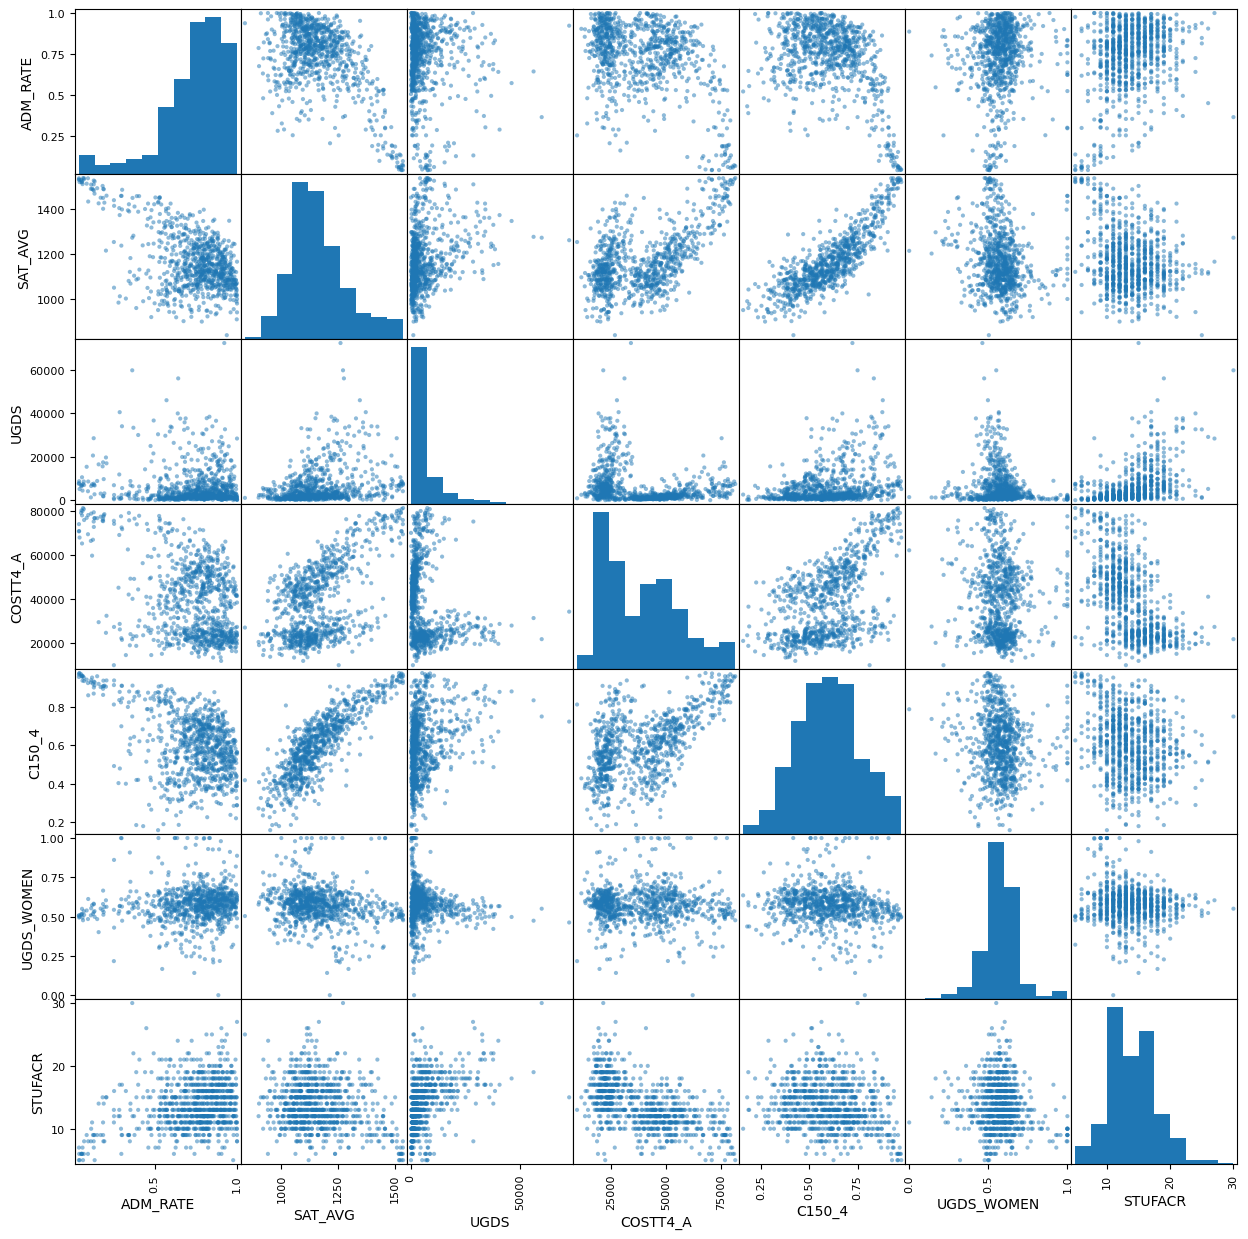

In [44]:
# Preliminary Visualization
cols = ["ADM_RATE", "SAT_AVG", "UGDS", "COSTT4_A", "C150_4", "UGDS_WOMEN", "STUFACR"]
response_column = "MD_EARN_WNE_1YR"
pd.plotting.scatter_matrix(data[cols], figsize=(15, 15))

# Define predictor variables and response
X = data[cols]
y = data["MD_EARN_WNE_1YR"]


A graphic overview of the dataset shows that among the 8 variables, variable UGDS is skewed to the left while ADM_RATE is skewed to the right. The plots for SAT_AVG and C150_4 seem to show correlation. These points would need to be studied closer. Furthermore, all variable plots show one datapoint being a significantly obvious outlier due to its positioning. 

## Part 1 : Regression Model and its initial findings

The purpose of the study is to determine a regression model to predict median earnings (MD_EARN_WNE_1YR) based on the other variables in the dataset

The formula would be:

    Median Earning = β0 + β1(Admission Rate) + β2(Average SAT) + β3(Undergrad) + β4(Cost of Attendance)+ β5(Cost of Attendace) + β6(Undergrad Women)  + β7(Student to Faculty Ratio) + β8(State) + ε
    
The view is that among the variables, there are some that would one or two variables that would adequately predict the likely earnings of the graduate.

In [68]:
# PART 1: Simple Regression Model
# Perform Regression and Print Summary
model = perform_regression(X, y)
residuals = model.resid


                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.92e-44
Time:                        08:19:01   Log-Likelihood:                -8989.4
No. Observations:                 851   AIC:                         1.799e+04
Df Residuals:                     843   BIC:                         1.803e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.44e+04   6241.833      3.908      0.0

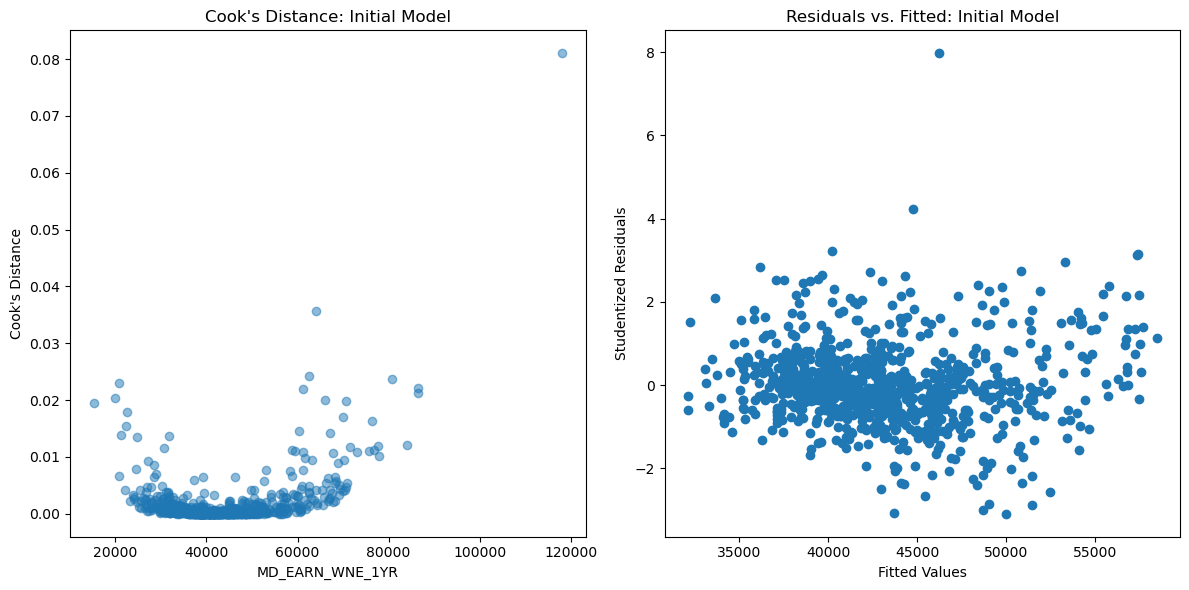

Most Influential Point Index: 375
Cook's Distance for Most Influential Point: 0.0810160313510398


In [49]:
# Plotting both influence and residuals in one function
most_influential = plot_cooks_and_residuals(model, data, "MD_EARN_WNE_1YR", "Initial Model")

A residual vs fitted plot is a scatter plot that shows the relationship between the residuals and the fitted values. A good regression model will have residuals that are randomly distributed around the zero line. This means that the model is doing a good job of predicting the variable, and there is no pattern in the residuals. From the plot, most of the plots are around the zero line showing that the regression model is able to adequately predict the median earnings. However, 

From the above two box plot, it can be seen that there is a influential point on the top of each plot. An influential point in a box plot is a data point that has a large impact on the overall shape of the box plot. This can happen if the data point is very far away from the rest of the data, or if it is located at a key point in the box plot, such as the median or the quartile. In this case, the influential point is very far away, thus affecting the shape of the box plot.

The index of the Most Influential Point is 375 and with a Cook's distance score of 0.081.

It is also noted that there is a outlier with a Cook's distance of around 0.034. However, the impact of this outlier to the findings is likely not significant when compared to the rest of the median earning.  

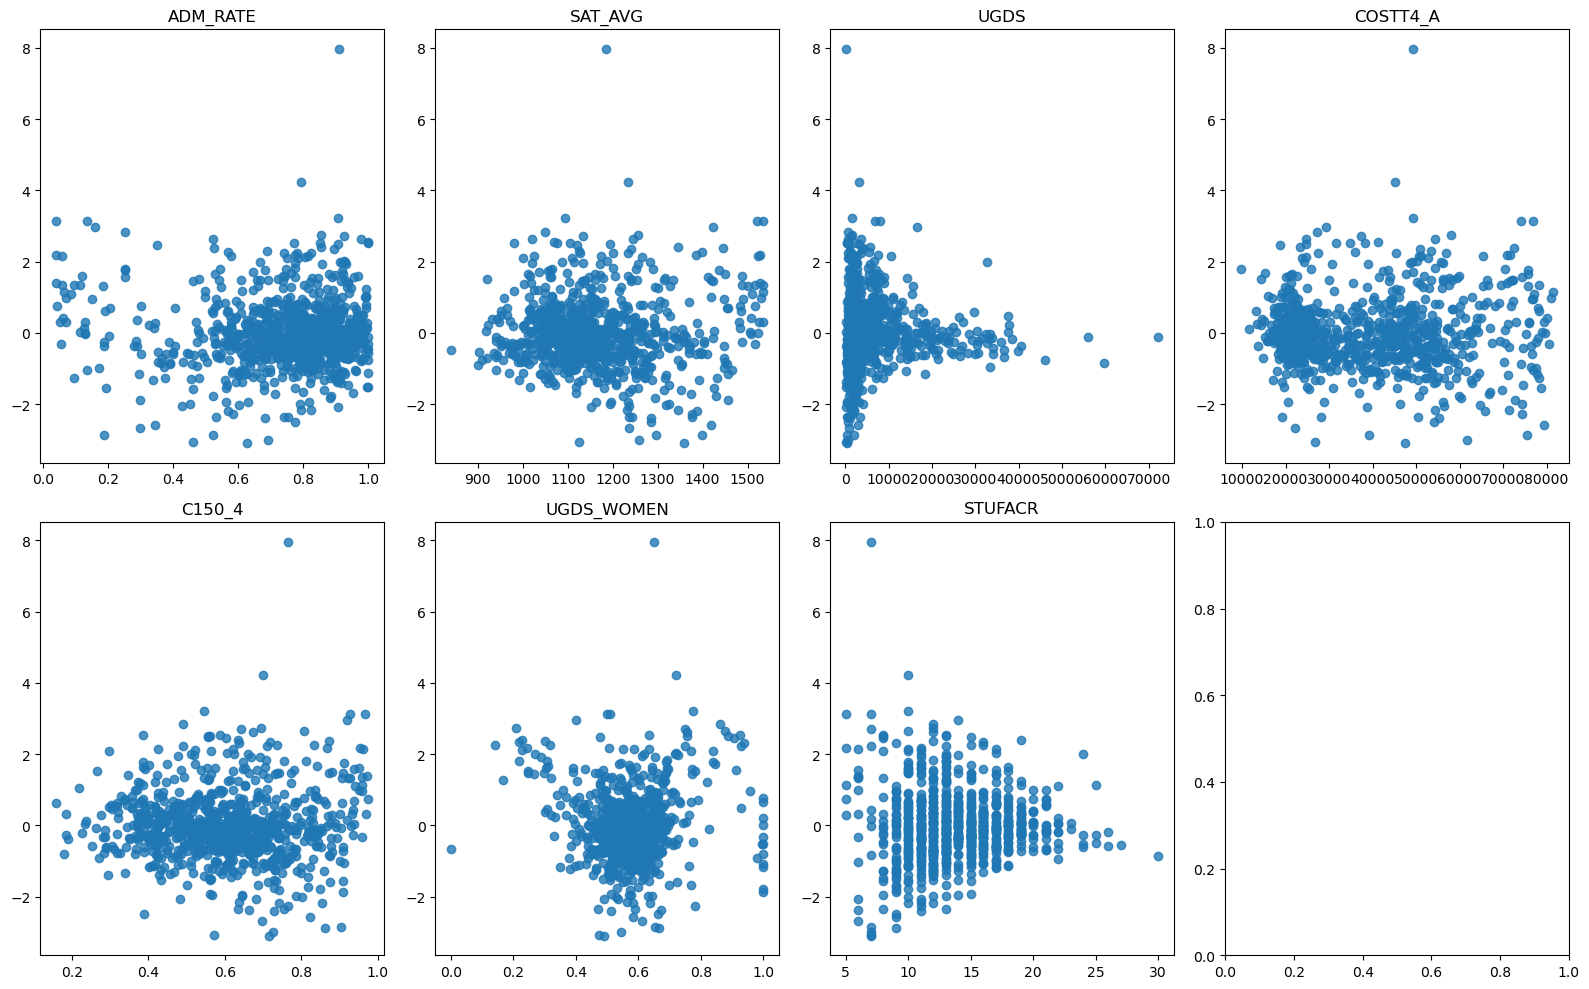

In [50]:
plot_residual_panels_8(model, X, cols)


From the box plot of the variables, the influential point mentioned previously is obvious on all of the plots. As such, this point would need to be studied and removed if necessary. 

It is also noted that the SAT_AVG variable is similar to the residual vs fitted model. While it is not definitive, there is a higher chance that this variable is important to predicting the median earnings. We would still need to study the relation and relevance of the other variables like "STUFACR" and "UGDS" as these two variables are skewed to the left.  

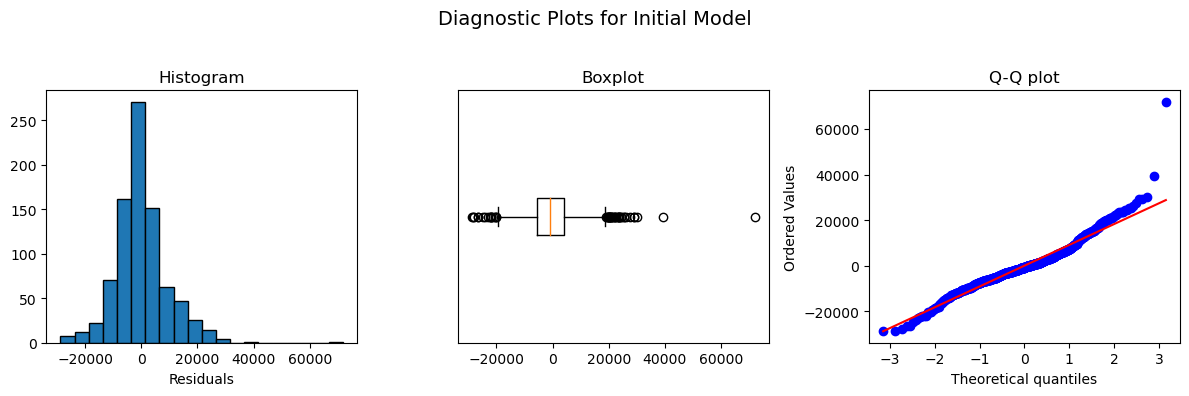

In [51]:
plot_diagnostic_panel(residuals, 'Diagnostic Plots for Initial Model')

In [52]:
# Variance Inflation Factor Calculation
calculate_print_vif(X)

     Variable         VIF
0       const  374.774286
1    ADM_RATE    1.480361
2     SAT_AVG    4.403443
3        UGDS    1.987787
4    COSTT4_A    2.442871
5      C150_4    3.741533
6  UGDS_WOMEN    1.074511
7     STUFACR    1.966060


Variance inflation factor (VIF) detects multicollinearity among a set of independent variables in a regression model. Multicollinearity occurs when two or more independent variables are highly correlated with each other. This can cause problems with the regression model, such as making it difficult to interpret the coefficients of the independent variables and leading to problems with model stability.

VIF of 1 indicates no multicollinearity between the variable of interest and the other independent variables. VIF between 1 and 5 indicate some multicollinearity, but it is not likely to cause serious problems.

The calculations show that among the 7 variables, SAT_AVG and C150_4 variables have a higher chance of multicollinearity but not significant enough to be of a concern as it is less than 5. More focus is to be given to these two to ensure that it doesnt go higher than 5 in further studies. 

In conclusion, there is no multicollinearity between the variables of concern from the initial analysis.  

## Part 2 : Standardize the Variables

After studying the initial findings, we now standardize the variables to see if there are any impact to the values.

The purpose of standardizing the variables in regression is to:

1. Make all variables on the same scale for easier interpretation and studies.
2. Reduce multicollinearity
3. Improve the accuracy of the model predictions.

In [53]:
# PART 2: Standardized Regression Model
scaled_columns = cols.copy()
data_scaled = standardize_data(data, scaled_columns)

model_2 = perform_regression(data_scaled[scaled_columns], data_scaled[response_column])

                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.92e-44
Time:                        08:13:48   Log-Likelihood:                -8989.4
No. Observations:                 851   AIC:                         1.799e+04
Df Residuals:                     843   BIC:                         1.803e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.32e+04    322.424    133.987      0.0

Comparisions of the two regression results show the following key differences:

Model Parameters:
The initial analysis showed that the coefficients for the variables was approximately 2.44e+04, while after standarization, the coefficient became higher to 4.32e+04.

Interpretation of Independent Variables:

The initial analysis showed the independent variables, 'SAT_AVG' and 'C150_4', have statistically significant coefficients (p-values less than 0.05), indicating they are important predictors of the dependent variable.
After standardization, the coefficients for 'SAT_AVG' and 'C150_4' are substantially larger and still statistically significant, suggesting a stronger relationship with the dependent variable.

R-squared and Adjusted R-squared:

The R-squared values for both models are the same (0.229), indicating that they explain a similar proportion of the variance in the dependent variable.
The adjusted R-squared values are also the same (0.223), which adjusts for the number of independent variables in the model.
F-statistic:

The F-statistic measures the overall significance of the regression model. In both sets of results, the F-statistic is the same (35.77), suggesting that the models are statistically significant.

In summary, the main differences between the two results are in the values of the coefficients for the independent variables and their associated p-values. The second set of results shows larger coefficients for some variables and a few additional significant predictors. This suggests a different set of independent variables was used in the two models, resulting in different parameter estimates. The goodness-of-fit statistics, including R-squared and the overall significance of the models, remain the same.

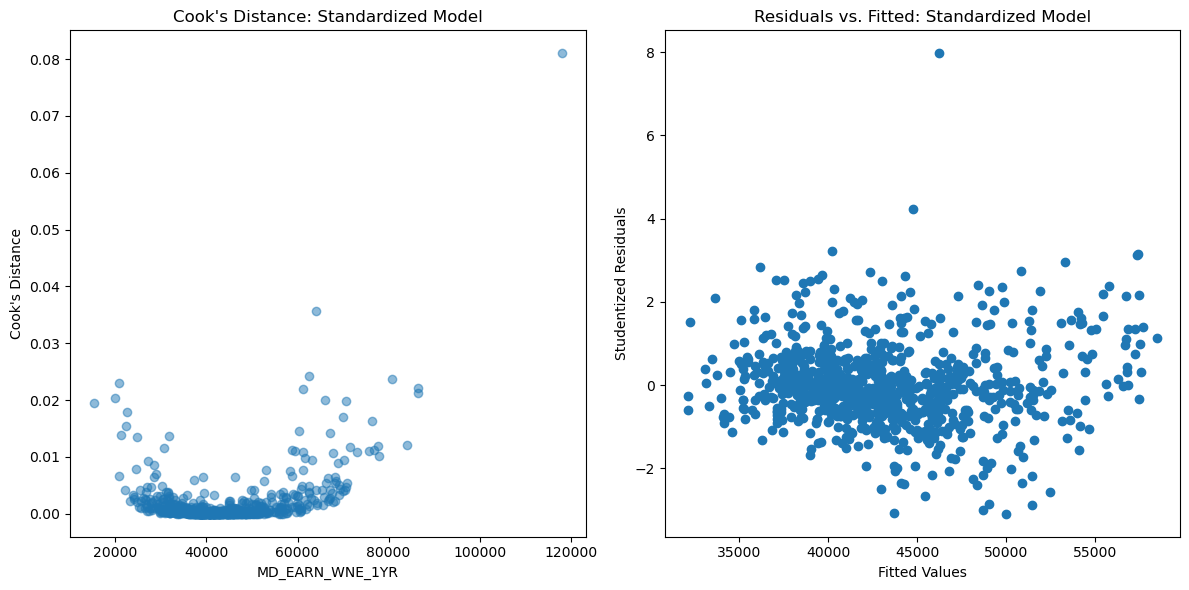

Most Influential Point Index: 375
Cook's Distance for Most Influential Point: 0.0810160313504177


In [54]:
residuals_2 = model_2.resid
most_influential_2 = plot_cooks_and_residuals(model_2, data_scaled, response_column, "Standardized Model")

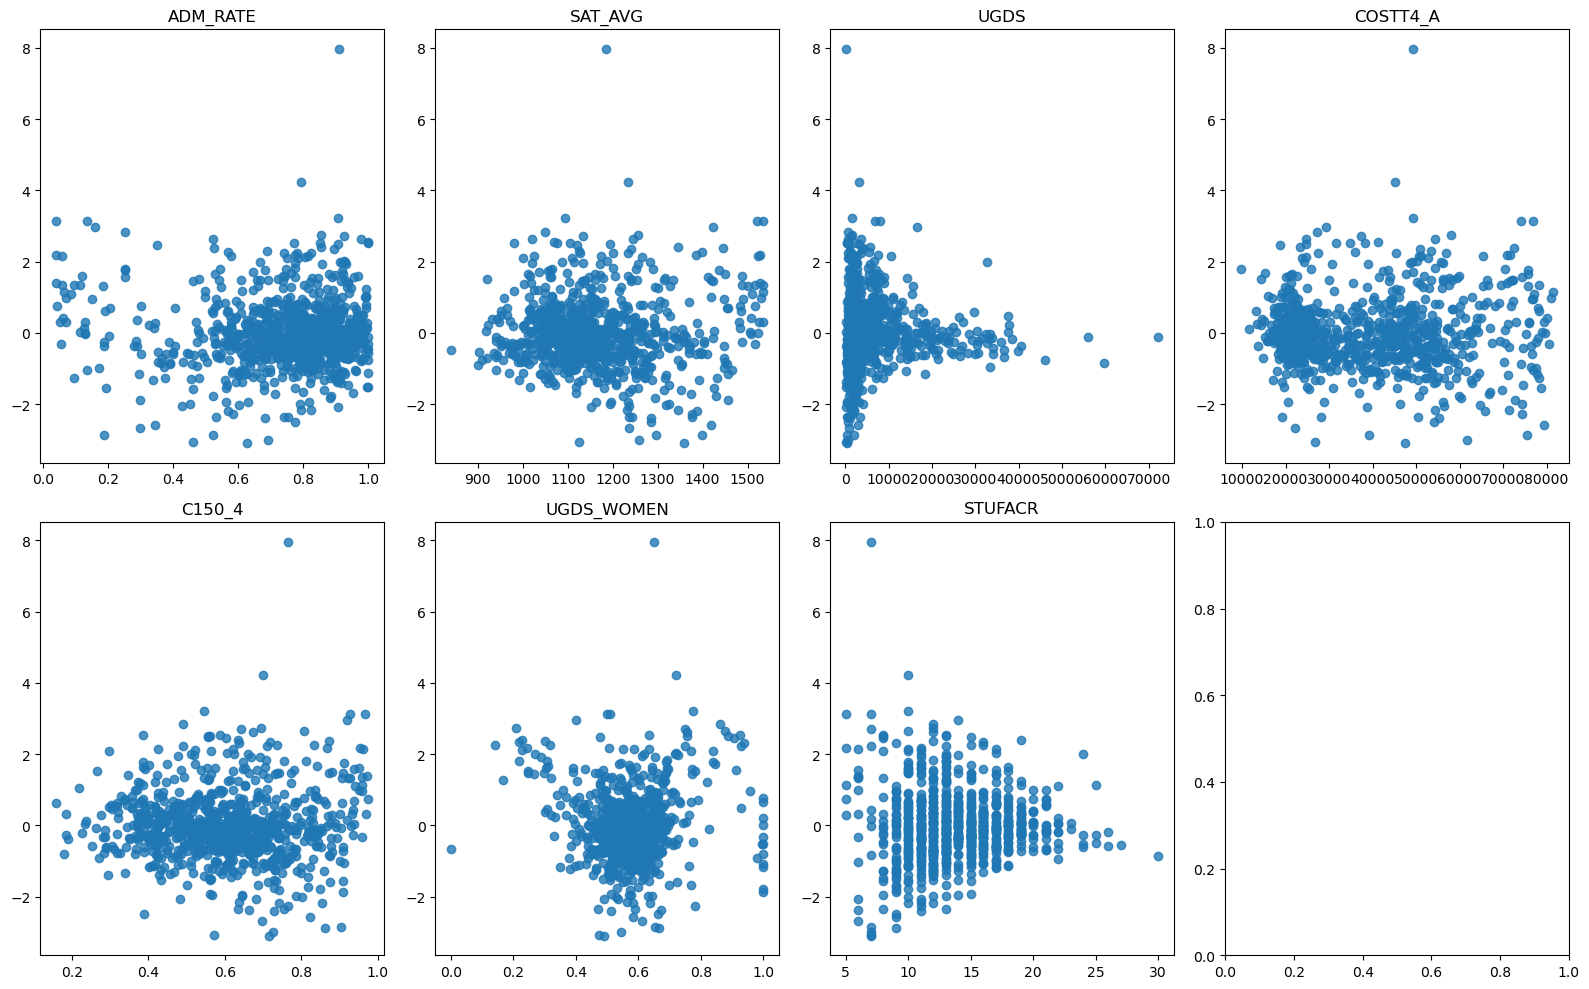

In [55]:
plot_residual_panels_8(model, X, cols)

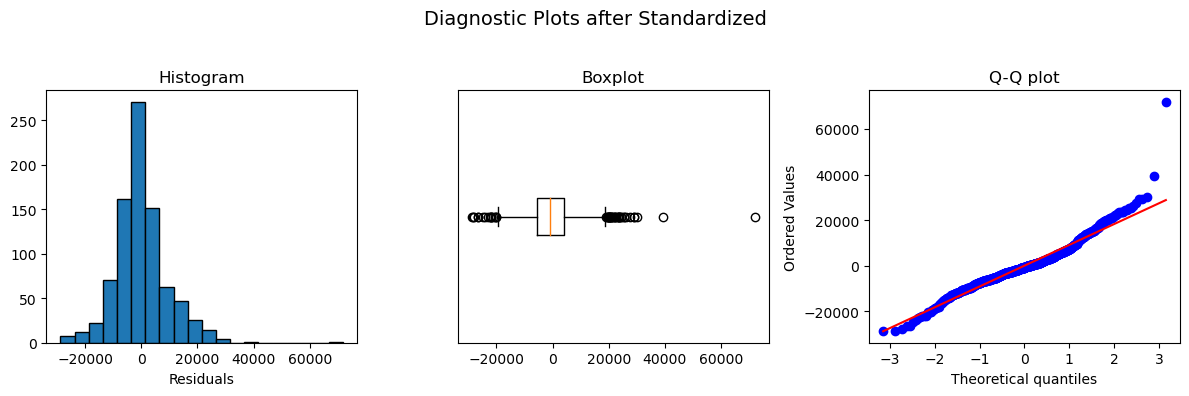

In [56]:
plot_diagnostic_panel(residuals_2, 'Diagnostic Plots after Standardized')

In [57]:
calculate_print_vif(data_scaled[scaled_columns])

     Variable       VIF
0       const  1.000000
1    ADM_RATE  1.480361
2     SAT_AVG  4.403443
3        UGDS  1.987787
4    COSTT4_A  2.442871
5      C150_4  3.741533
6  UGDS_WOMEN  1.074511
7     STUFACR  1.966060


## Part 3 : Adding in the "State" Variable

After studying the initial findings, we now standardize the variable to see if there is any impact to the values.

In [58]:
# PART 3: Adding State Variable After One Hot Encoding
data_encoded = one_hot_encode(data_scaled, 'STATE')
all_columns = [col for col in data_encoded.columns if col != response_column]
model_3 = perform_regression(data_encoded[all_columns], data_encoded[response_column])

                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     6.279
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           3.53e-35
Time:                        08:13:51   Log-Likelihood:                -8944.0
No. Observations:                 851   AIC:                         1.800e+04
Df Residuals:                     794   BIC:                         1.827e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


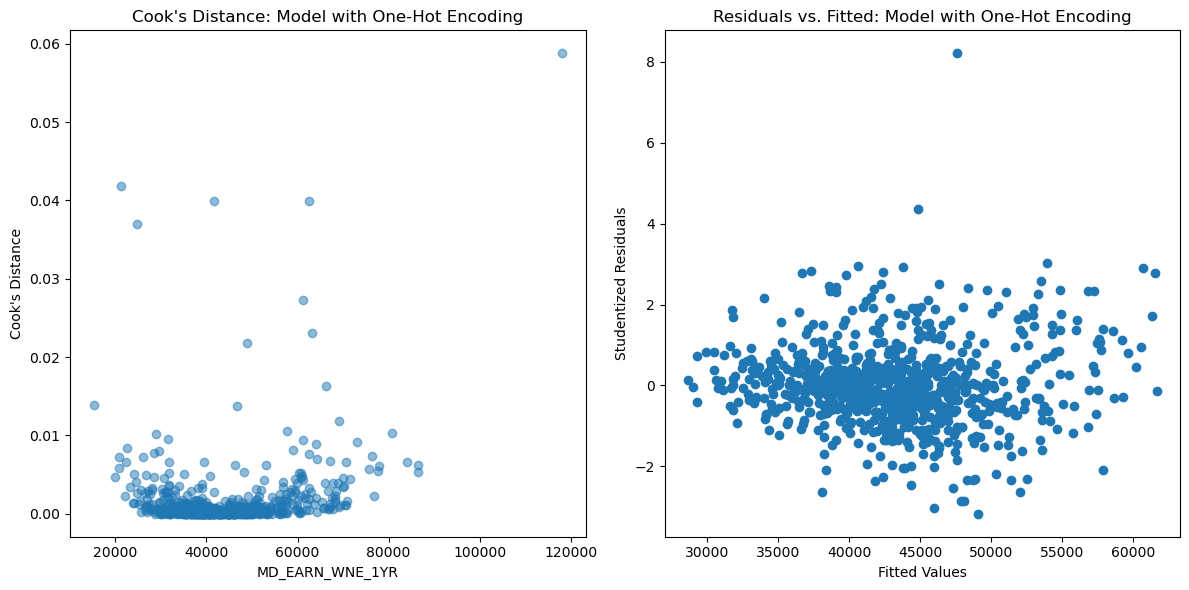

Most Influential Point Index: 397
Cook's Distance for Most Influential Point: nan


In [59]:
most_influential_3 = plot_cooks_and_residuals(model_3, data_encoded, response_column, "Model with One-Hot Encoding")

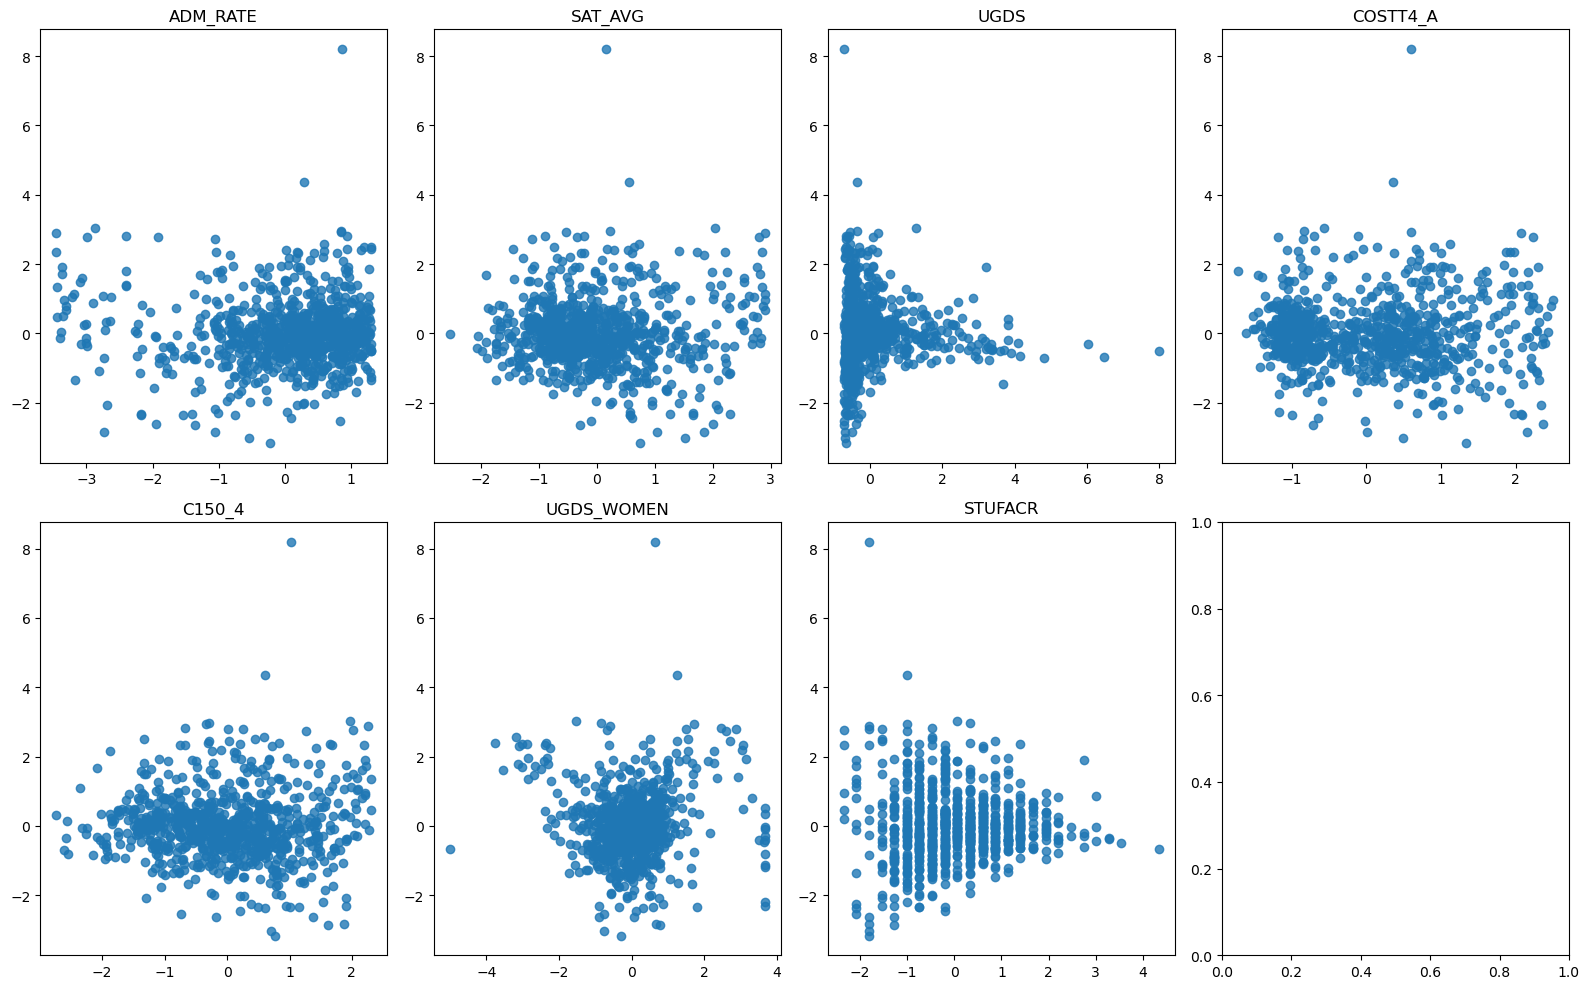

In [60]:
plot_residual_panels_8(model_3, data_encoded, cols)

In [61]:
calculate_print_vif(data_encoded[all_columns])

                      Variable        VIF
0                        const  61.994058
1                 STATE_Alaska   1.079032
2                STATE_Arizona   1.158700
3               STATE_Arkansas   1.772049
4             STATE_California   3.011003
5               STATE_Colorado   1.917393
6            STATE_Connecticut   2.023490
7               STATE_Delaware   1.080557
8   STATE_District of Columbia   1.383745
9                STATE_Florida   3.101860
10               STATE_Georgia   2.846532
11                STATE_Hawaii   1.211781
12                 STATE_Idaho   1.218360
13              STATE_Illinois   3.315680
14               STATE_Indiana   2.977857
15                  STATE_Iowa   2.162290
16                STATE_Kansas   1.800266
17              STATE_Kentucky   1.836993
18             STATE_Louisiana   2.185080
19                 STATE_Maine   1.217497
20              STATE_Maryland   1.781856
21         STATE_Massachusetts   3.632363
22              STATE_Michigan   2

In [62]:
#Part 4 Remove the Most Influential Point
influence_2 = model_2.get_influence()
cooks_distance_2 = influence_2.cooks_distance[0]
most_influential_2 = np.argmax(cooks_distance_2)
data_scaled_less_influential = data_scaled.drop(data_scaled.index[most_influential_2])
data_scaled_less_influential_encoded = one_hot_encode(data_scaled_less_influential, 'STATE')

# Correcting column generation after encoding
state_columns = [col for col in data_scaled_less_influential_encoded.columns if 'STATE_' in col]
all_columns_less_influential = state_columns + scaled_columns

model_4 = perform_regression(data_scaled_less_influential_encoded[all_columns_less_influential], 
                             data_scaled_less_influential_encoded[response_column])
residuals_4 = model_4.resid

                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     6.717
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.75e-38
Time:                        08:14:03   Log-Likelihood:                -8899.4
No. Observations:                 850   AIC:                         1.791e+04
Df Residuals:                     793   BIC:                         1.818e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


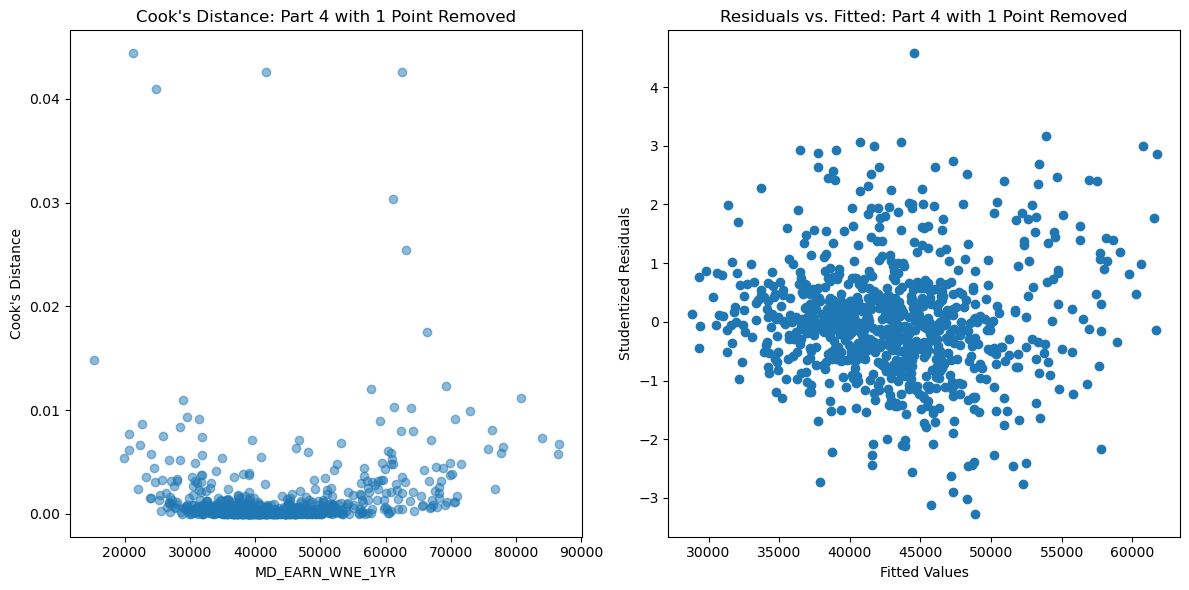

Most Influential Point Index: 396
Cook's Distance for Most Influential Point: nan


In [63]:
# Analyzing model_4
most_influential_4 = plot_cooks_and_residuals(model_4, data_scaled_less_influential_encoded, response_column, "Part 4 with 1 Point Removed")

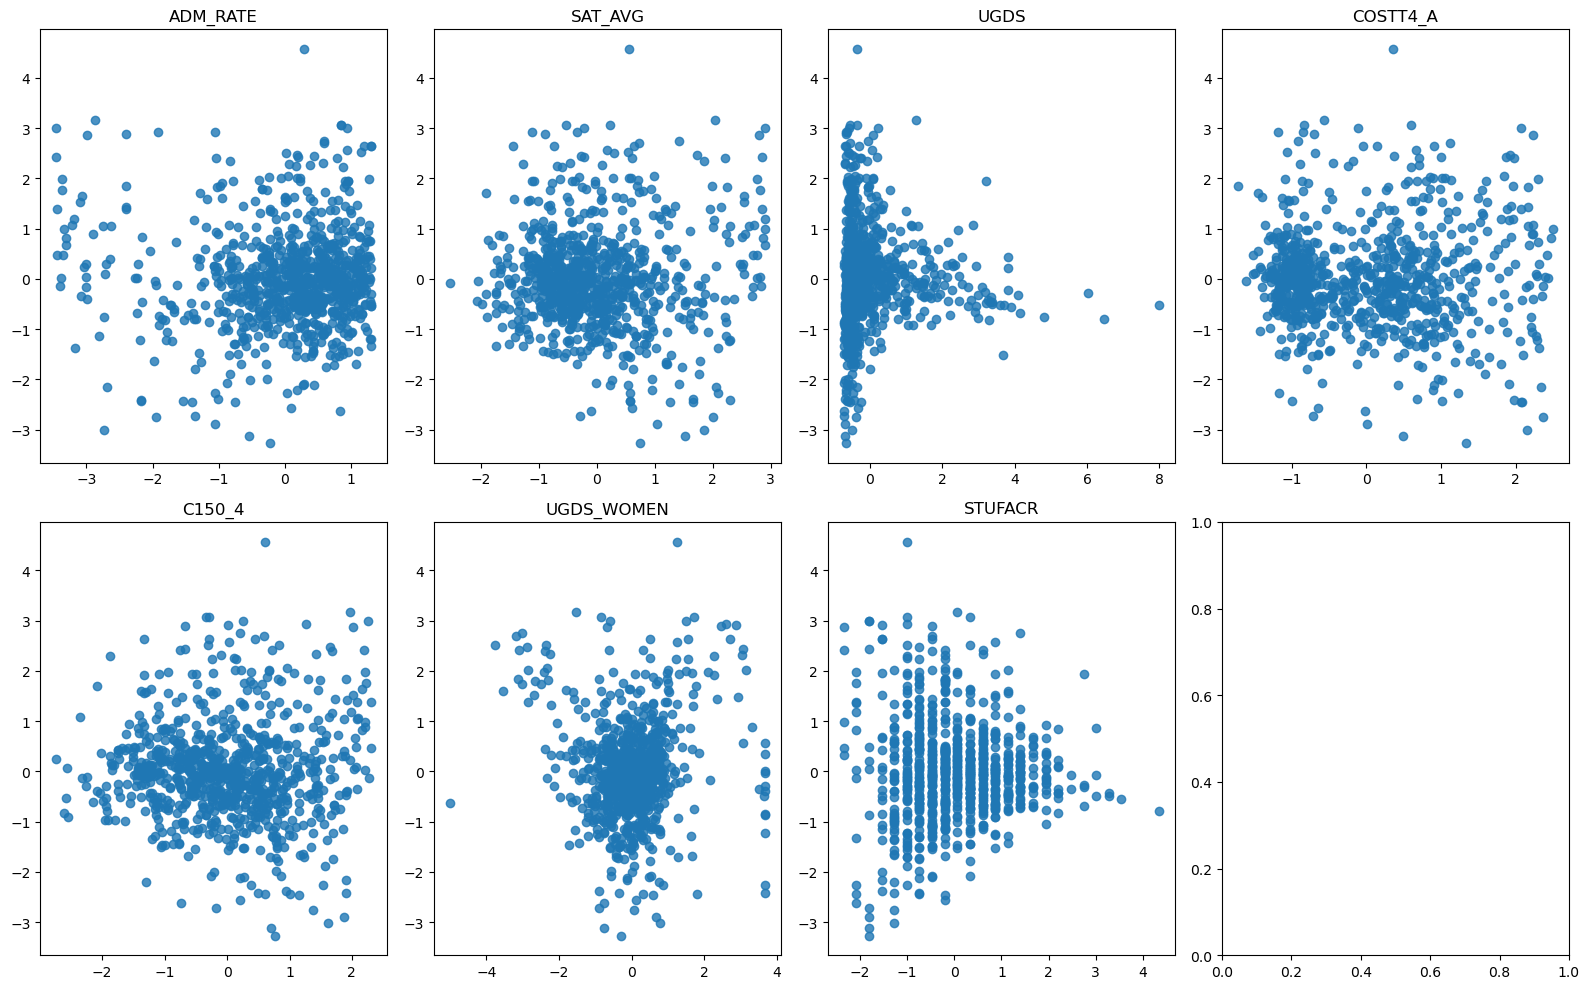

In [64]:
plot_residual_panels_8(model_4, data_scaled_less_influential_encoded, cols)

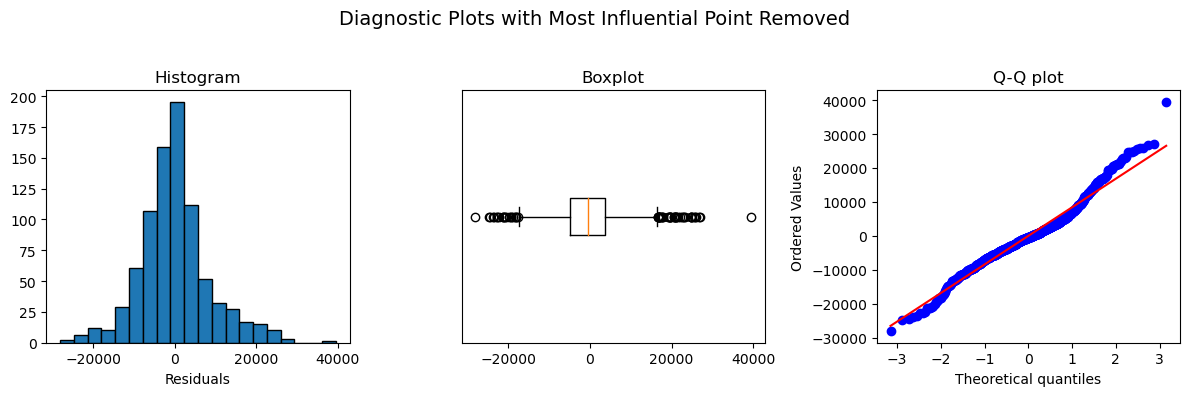

In [65]:
plot_diagnostic_panel(residuals_4, 'Diagnostic Plots with Most Influential Point Removed')

In [66]:
calculate_print_vif(data_scaled_less_influential_encoded[all_columns_less_influential])

                      Variable        VIF
0                        const  61.928143
1                 STATE_Alaska   1.079046
2                STATE_Arizona   1.158702
3               STATE_Arkansas   1.772023
4             STATE_California   3.011468
5               STATE_Colorado   1.917368
6            STATE_Connecticut   2.023565
7               STATE_Delaware   1.080606
8   STATE_District of Columbia   1.383799
9                STATE_Florida   3.101748
10               STATE_Georgia   2.846447
11                STATE_Hawaii   1.211776
12                 STATE_Idaho   1.218385
13              STATE_Illinois   3.316027
14               STATE_Indiana   2.978580
15                  STATE_Iowa   2.162537
16                STATE_Kansas   1.800312
17              STATE_Kentucky   1.836997
18             STATE_Louisiana   2.185133
19                 STATE_Maine   1.217547
20              STATE_Maryland   1.781946
21         STATE_Massachusetts   3.632529
22              STATE_Michigan   2